In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy.sparse.linalg import lsqr
from scipy.optimize import leastsq
from cycler import cycler
from matplotlib.pyplot import cm

In [2]:
data = np.load("circles.npy")

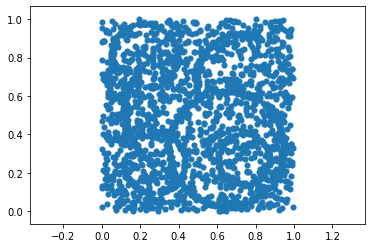

In [17]:
plt.axis('equal')
plt.scatter(data[:,0], data[:,1], linewidths = 0.1)

# 4.1 RANSAC

In [4]:
def circumcircle(x1,x2,x3): #based on https://mathworld.wolfram.com/Circumcircle.html
    A = np.array([[x1[0],x1[1],1],[x2[0],x2[1],1], [x3[0],x3[1],1]])
    B1 = np.array([[x1[0]**2 + x1[1]**2,x1[1], 1],[x2[0]**2 + x2[1]**2,x2[1], 1], [x3[0]**2 + x3[1]**2,x3[1], 1]])
    B2 = np.array([[x1[0]**2 + x1[1]**2,x1[0], 1],[x2[0]**2 + x2[1]**2,x2[0], 1], [x3[0]**2 + x3[1]**2,x3[0], 1]])
    C = np.array([[x1[0]**2 + x1[1]**2,x1[0], x1[1]],[x2[0]**2 + x2[1]**2,x2[0], x2[1]], [x3[0]**2 + x3[1]**2,x3[0], x3[1]]])
    a = LA.det(A)
    bx = -LA.det(B1)
    by = LA.det(B2)
    c = -LA.det(C)
    r = np.sqrt(bx**2+by**2-4*a*c)/(2*np.abs(a))
    x0 = -bx/(2*a)
    y0 = -by/(2*a) 
    return r,x0,y0

In [5]:
def distance_from_circle(r, x0, y0, data):
    distance_from_center = np.sqrt((data[:,0]-x0)**2+(data[:,1]-y0)**2)
    difference = np.abs(r - distance_from_center)
    return difference
    

In [6]:
def RANSAC(data,N,epsilon,number_circles):
    circles = []
    for i in range(number_circles):
        r = 0
        x0 = 0
        y0 = 0
        distance_max = np.zeros(data.shape)
        count_inlier = 0
        for i in range(N):
            random_numbers = np.random.choice(len(data), 3,replace = False)
            x1 = data[random_numbers[0]]
            x2 = data[random_numbers[1]]
            x3 = data[random_numbers[2]]
            r_actual, x0_actual, y0_actual = circumcircle(x1,x2,x3)
            distance = distance_from_circle(r_actual, x0_actual, y0_actual, data)
            inliers_array = np.where(distance<epsilon, 1, 0)
            count = np.count_nonzero(inliers_array)
            if count>count_inlier:
                r = r_actual
                x0 = x0_actual
                y0 = y0_actual
                count_inlier = count
                distance_max = distance
        circles.append([r,x0,y0])
        data = np.delete(data,np.where(distance_max<epsilon),axis=0 )
    return np.array(circles)

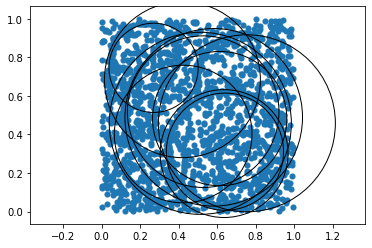

In [18]:
circles = RANSAC(data, 100, 0.01,10)
plt.scatter(data[:,0], data[:,1], linewidths = 0.1)
plt.axis('equal')
for i in range(len(circles)):
    x0 = circles[i,1]
    y0= circles[i,2]
    r=circles[i,0]
    circle = plt. Circle ((x0 , y0), radius =r, fill = False ) # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot

# 4.2 Algebraic Distance

In [8]:
def algebraic_distance(inliers):
    ones = np.full(len(inliers),1)
    X = np.concatenate((inliers, ones.T[:,np.newaxis]), axis =1)
    Y = inliers[:,0]**2 + inliers[:,1]**2
    beta = np.array(lsqr(X, Y)[0])
    x0 = beta[0]/2
    y0 = beta[1]/2
    r = np.sqrt(beta[2] +x0**2 + y0**2) #There is an error on the skript
    #circle = np.stack((r, x0, y0), axis=-1)
    return r,x0,y0

In [9]:
def inliers_generator(data,N,epsilon,number_circles):
    circles = RANSAC(data,N,epsilon,number_circles)
    inliers_array = []
    for i in range(len(circles)):
        r_actual = circles[i,0]
        x0_actual = circles[i,1]
        y0_actual = circles[i,2]
        distance = distance_from_circle(r_actual, x0_actual, y0_actual, data)
        inliers = data[np.where(distance<epsilon)]
        inliers_array.append(inliers)
    return np.array(inliers_array)

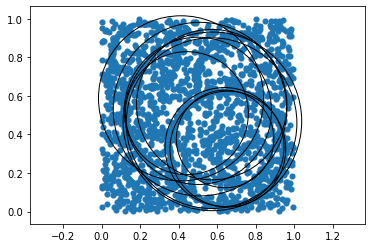

In [19]:
plt.scatter(data[:,0], data[:,1], linewidths = 0.1)
inliers = inliers_generator(data, 100, 0.001,10)
plt.axis('equal')
for i in range(len(inliers)):
    r,x0,y0 = algebraic_distance(inliers[i])
    circle = plt. Circle ((x0 , y0), radius =r, fill = False ) # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot

# 4.3 Levenberg-Marquardt

In [11]:
def residuals(c,t):
    return c[0] - np.sqrt((t[:,0]-c[1])**2 +(t[:,1]-c[2])**2)

In [12]:
def Levenberg_Marquardt(circles):
    x0 = [0.5,0.5,0.5]
    x,flag = leastsq(residuals,x0, args= (circles))
    return x

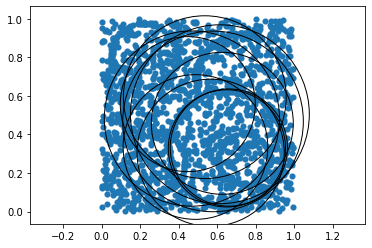

In [20]:
plt.scatter(data[:,0], data[:,1], linewidths = 0.1)
inliers = inliers_generator(data, 100, 0.001,10)
plt.axis('equal')
for i in range(len(inliers)):
    r,x0,y0 = Levenberg_Marquardt(inliers[i])
    circle = plt. Circle ((x0 , y0), radius =r, fill = False ) # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot

# 4.4 Comparison

### Generate a circle with outliers

In [14]:
def circle_with_outliers(r,x0,y0,N_inliers, N_outliers):
    radians =np.arange(0,2*np.pi + np.pi/N_inliers, np.pi/N_inliers)
    x = x0_real + r_real* np.cos(radians) +np.random.normal(scale =0.05,size= radians.shape)
    y= y0_real +r_real* np.sin(radians)+np.random.normal(scale= 0.05,size= radians.shape)
    circles = np.stack((x,y),axis= 1)
    x =np.random.uniform(low = 0, high = 1,size = N_outliers)
    y = np.random.uniform(low = 0, high = 1, size = N_outliers)
    outliers = np.stack((x, y), axis=-1)
    new_data = np.concatenate((circles, outliers),axis = 0)
    return new_data

### Experiment

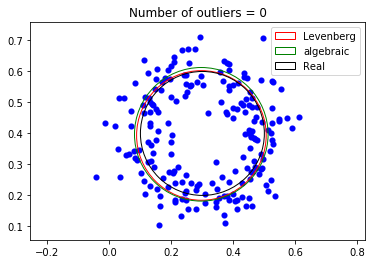

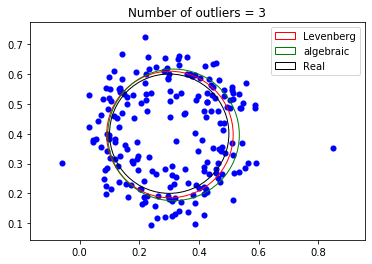

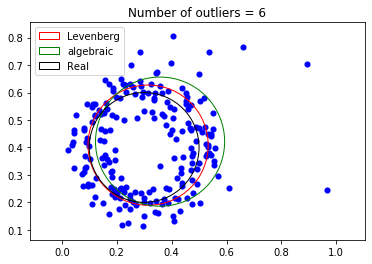

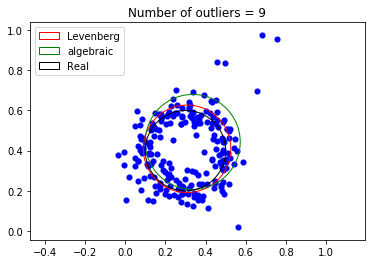

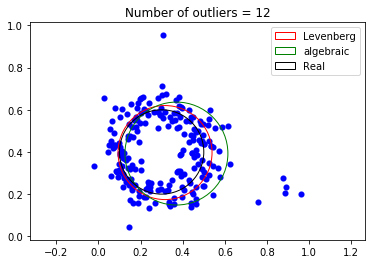

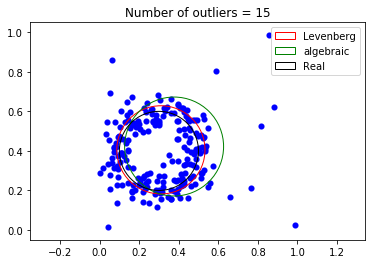

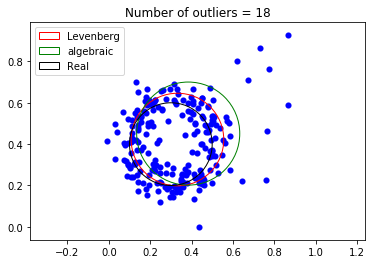

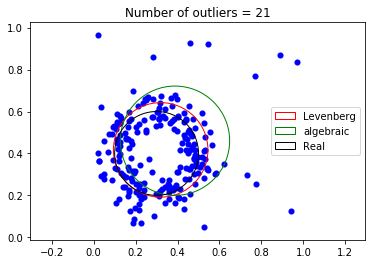

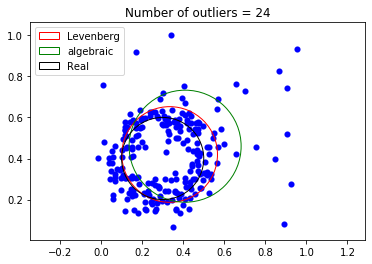

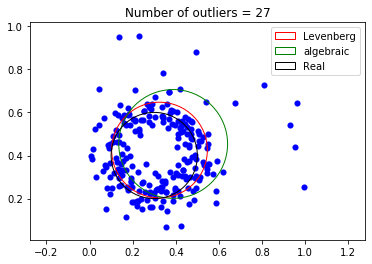

In [21]:
x0_real = 0.3
y0_real = 0.4
r_real = 0.2
N_inliers = 100
N_outliers = 0
algebraic = []
Levenberg = []
for i in range(10):
    new_data = circle_with_outliers(r_real ,x0_real ,y0_real ,N_inliers, N_outliers)
    #r,x0,y0 = algebraic_distance(new_data)
    #algebraic.append([r,x0,y0])
    #r,x0,y0 =Levenberg_Marquardt(new_data)
    #Levenberg.append([r,x0,y0])
    plt.figure(i)
    plt.axis('equal')
    plt.title("Number of outliers = " + str(N_outliers))
    #the points
    plt.scatter(new_data[:,0], new_data[:,1], linewidths = 0.1,color = 'blue')
    #color=iter(cm.rainbow(np.linspace(0,1,10)))
    #c=next(color)
    r,x0,y0 =Levenberg_Marquardt(new_data)
    circle = plt. Circle ((x0 , y0), radius =r, fill = False ,label  ="Levenberg",color = "red") # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot
    #c=next(color)
    r,x0,y0 = algebraic_distance(new_data)
    circle = plt. Circle ((x0 , y0), radius =r, fill = False , label  ="algebraic",color = "green") # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot
    #c=next(color)
    circle = plt. Circle ((x0_real , y0_real), radius =r_real, fill = False , label  ="Real",color = "black") # Create a circle
    plt.gca (). add_patch ( circle ) # Add it to the plot
    plt.legend()
    N_outliers = N_outliers +3

Clearly the solution using the Levenberg-Marquardt is more robust to outliers to the method with algebraic Distance!!